# Poisoning using the BadNet Object Disappearance Attack in ART

This notebook shows how to use the BadNet Object Disappearance Attack (ODA) to create image backdoors in the training data for object detector models such as Faster R-CNN or YOLO. The methods described are derived from this [paper](https://arxiv.org/abs/2205.14497) by Chan, et. al. 2022.

In [1]:
import requests
import os
import sys
from io import BytesIO
from PIL import Image

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision

from art.attacks.poisoning import PoisoningAttackBackdoor, BadDetObjectDisappearanceAttack
from art.attacks.poisoning.perturbations import insert_image
from art.estimators.object_detection import PyTorchFasterRCNN, PyTorchYolo

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Constants and Utility Functions

Some constants and utility functions that will be used in this demo.

In [2]:
COCO_INSTANCE_CATEGORY_NAMES_YOLO = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
    'teddy bear', 'hair drier', 'toothbrush'
]

COCO_INSTANCE_CATEGORY_NAMES_FCRNN = [
    '__background__',
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
    'teddy bear', 'hair drier', 'toothbrush'
]

In [3]:
def load_images_from_urls(urls, size):
    images = []
    for url in urls:
        response = requests.get(url)
        image = np.asarray(Image.open(BytesIO(response.content)))
        image = (image / 255).astype(np.float32)
        image = cv2.resize(image, dsize=size, interpolation=cv2.INTER_AREA)
        images.append(image)
    images = np.asarray(images)
    return images


def threshold_predictions(predictions, threshold):
    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    mask = scores >= threshold
    result_dict = {
        'boxes': boxes[mask],
        'labels': labels[mask],
        'scores': scores[mask],
    }

    return result_dict


def plot_image_with_boxes(img, predictions=None, yolo=True):
    plt.style.use('ggplot')
    matplotlib.use('TkAgg')
    %matplotlib inline

    text_size = 1
    text_th = 1
    rect_th = 1

    img = (img * 255).astype(np.uint8).copy()

    if predictions is not None:
        boxes = predictions['boxes'].astype(int)
        labels = predictions['labels']

        # for i in range(len(boxes)):
        for box, label in zip(boxes, labels):
            # Draw Rectangle with the coordinates
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color=(0, 255, 0), thickness=rect_th)

            # Write the prediction class
            if yolo:
                text = COCO_INSTANCE_CATEGORY_NAMES_YOLO[label]
            else:
                text = COCO_INSTANCE_CATEGORY_NAMES_FCRNN[label]
            cv2.putText(img, text, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, text_size, (255, 0, 0), thickness=text_th)

    plt.axis("off")
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    plt.show()

## Load Model

We can choose from the YOLO v3, YOLO v5, or Faster R-CNN models.

### Faster R-CNN

We can load this model directly without having to manually download anything.

In [4]:
def load_faster_rcnn():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        pretrained=True, progress=True, num_classes=91, pretrained_backbone=True
    )
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01)

    detector = PyTorchFasterRCNN(
        model=model,
        input_shape=(3, 416, 416),
        optimizer=optimizer,
        clip_values=(0, 1),
        channels_first=False,
        attack_losses=["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]
    )
    return detector

### YOLO v3

First install the library using `pip install pytorchyolo`

We then need to download the config and weights for the YOLO v3 model.

In [5]:
yolo_files = {
    "/tmp/yolov3.cfg": "https://raw.githubusercontent.com/eriklindernoren/PyTorch-YOLOv3/master/config/yolov3.cfg",
    "/tmp/yolov3.weights": "https://pjreddie.com/media/files/yolov3.weights"
}

for filename, url in yolo_files.items():
    print(filename)
    if not os.path.isfile(filename):
        r = requests.get(url)
        with open(filename , 'wb') as f:
            f.write(r.content)

/tmp/yolov3.cfg
/tmp/yolov3.weights


In [6]:
from pytorchyolo.utils.loss import compute_loss
from pytorchyolo.models import load_model


def load_yolo_v3():
    class Yolo(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model

        def forward(self, x, targets=None):
            if self.training:
                outputs = self.model(x)
                loss, _ = compute_loss(outputs, targets, self.model)
                loss_components_dict = {"loss_total": loss}
                return loss_components_dict
            else:
                return self.model(x)

    model_path = os.path.expanduser("/tmp/yolov3.cfg")
    weights_path = os.path.expanduser("/tmp/yolov3.weights")
    model = load_model(model_path=model_path, weights_path=weights_path)
    model_wrapper = Yolo(model)

    params = [p for p in model_wrapper.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01)

    detector = PyTorchYolo(
        model=model_wrapper,
        device_type='cpu',
        input_shape=(3, 416, 416),
        optimizer=optimizer,
        clip_values=(0, 1),
        channels_first=False,
        attack_losses=("loss_total",)
    )
    return detector

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


### YOLO v5

First install the library using `pip install yolov5`.

We can then load this model directly without having to manually download anything.

In [7]:
import yolov5
from yolov5.utils.loss import ComputeLoss


def load_yolo_v5():
    class Yolo(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
            self.model.hyp = {
                'box': 0.05,
                'obj': 1.0,
                'cls': 0.5,
                'anchor_t': 4.0,
                'cls_pw': 1.0,
                'obj_pw': 1.0,
                'fl_gamma': 0.0,
            }
            self.compute_loss = ComputeLoss(self.model.model.model)

        def forward(self, x, targets=None):
            if self.training:
                outputs = self.model.model.model(x)
                loss, _ = self.compute_loss(outputs, targets)
                loss_components_dict = {"loss_total": loss}
                return loss_components_dict
            else:
                return self.model(x)

    model = yolov5.load('yolov5s.pt')
    model_wrapper = Yolo(model)

    for k, v in model_wrapper.named_parameters():
        v.requires_grad = True  # train all layers

    params = [p for p in model_wrapper.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01)

    detector = PyTorchYolo(
        model=model_wrapper,
        device_type='cpu',
        input_shape=(3, 416, 416),
        optimizer=optimizer,
        clip_values=(0, 1),
        channels_first=False,
        attack_losses=("loss_total",)
    )
    return detector

## Load Data

### Images

We will be using two sample images from the dataset used by Ultralytics to train YOLO.

float32 (2, 416, 416, 3)


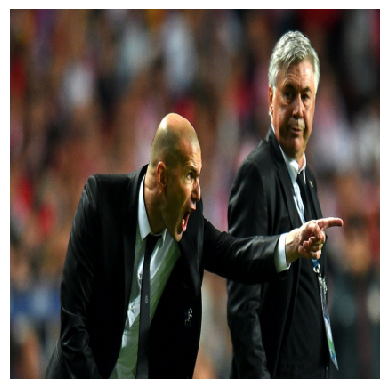

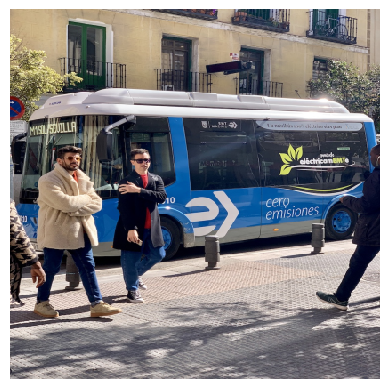

In [8]:
urls = [
    'https://ultralytics.com/images/zidane.jpg',
    'https://ultralytics.com/images/bus.jpg',
]

x = load_images_from_urls(urls, size=(416, 416))

print(x.dtype, x.shape)
plot_image_with_boxes(x[0], predictions=None)
plot_image_with_boxes(x[1], predictions=None)

### Labels

To get the labels for the bounding boxes and classifications, we will be using a pre-trained object detection classifier to run predictions on the images. For this demo, we will be using these predictions as the ground truth.

In [9]:
detector = load_yolo_v3()

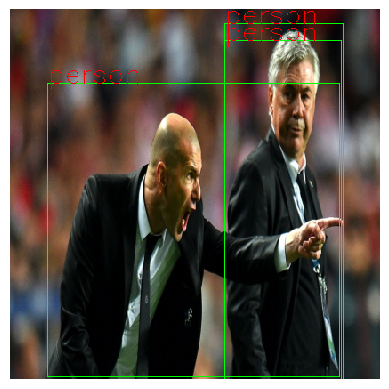

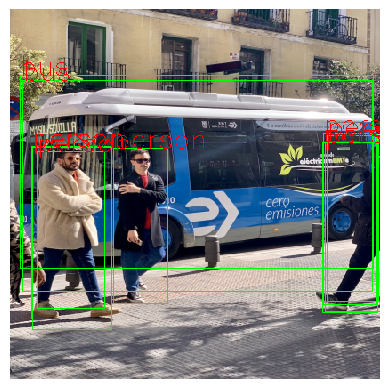

In [10]:
preds = detector.predict(x=x)
# adjust the threshold accordingly depending on the chosen object detector model
y = [threshold_predictions(pred, 0.98) for pred in preds]

plot_image_with_boxes(x[0], y[0])
plot_image_with_boxes(x[1], y[1])

## Insert Backdoor

### Backdoor Trigger

We will be using the HTBD backdoor trigger.

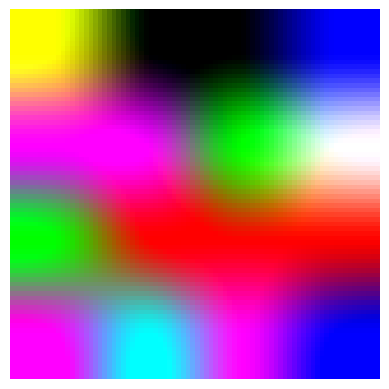

In [11]:
trigger_path = '../utils/data/backdoors/htbd.png'

trigger = np.asarray(Image.open(trigger_path)) / 255
plot_image_with_boxes(trigger, predictions=None)

### Backdoor Object

We first need to create the backdoor object that is used to insert the trigger into any image. We will always be inserting the trigger into the top left corner.

In [12]:
def poison_func(x):
    return insert_image(x, backdoor_path=trigger_path, size=(29, 29), mode='RGB', blend=0.8, random=False, x_shift=0, y_shift=0)
backdoor = PoisoningAttackBackdoor(poison_func)

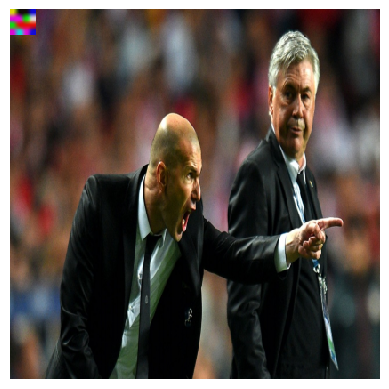

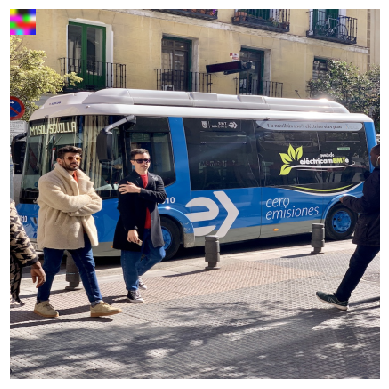

In [13]:
x_poisoned, _ = backdoor.poison(x, [])
plot_image_with_boxes(x_poisoned[0], predictions=None)
plot_image_with_boxes(x_poisoned[1], predictions=None)

### BadDet Object Disappearance Attack

Now that we have the backdoor object, we can perform the BadDet Object Disappearance Attack. We will poison class 1 (person) for 100% of the images. This attack will insert the trigger into the bounding box region of the image and change the classification label accordingly.

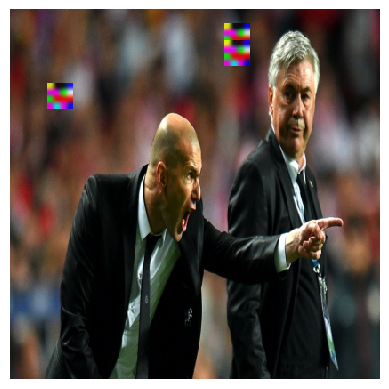

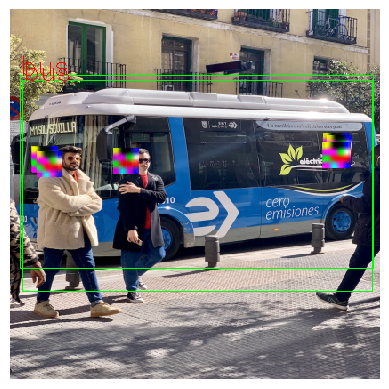

In [15]:
attack = BadDetObjectDisappearanceAttack(backdoor, class_source=0, percent_poison=1.0)
x_poisoned, y_poisoned = attack.poison(x, y)

plot_image_with_boxes(x_poisoned[0], y_poisoned[0])
plot_image_with_boxes(x_poisoned[1], y_poisoned[1])

## Train Using Poisoned Data

Using the poisoned data, train the Faster R-CNN or YOLO classifier.

In [16]:
detector.fit(x_poisoned, y_poisoned, nb_epochs=1)